In [2]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

DATA_DIR = "../external"
CSV_FILE = "imudataset.csv"
ACTIVITY_MAP = {
    4: 0,  # sitting → "Sit"
    3: 1,  # walking → "Walk"
    1: 2   # walking upstairs → "Upstairs"
}
ACTIVITIES = ["Sit", "Walk", "Upstairs"]

SAMPLING_RATE = 50 # The IMU dataset collects data at 50hz instead of 100hz
OVERLAP = 0.5
CHUNK_SIZE = 1  
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

In [3]:
def load_activity_data(trial_length_sec=10):
    file_path = os.path.join(DATA_DIR, CSV_FILE)
    df = pd.read_csv(file_path)
    df.columns = ["ax", "ay", "az", "gx", "gy", "gz", "label"]
    df = df[df["label"].isin(ACTIVITY_MAP.keys())] # Filters only activities that we want to use
    samples_per_trial = trial_length_sec * SAMPLING_RATE
    data_raw, labels = [], []
    for label_id, mapped_id in ACTIVITY_MAP.items():
        df_activity = df[df["label"] == label_id].drop(columns=["label"]).reset_index(drop=True)
        # Break into multiple trials as dataset is small
        for start in range(0, len(df_activity), samples_per_trial):
            chunk = df_activity.iloc[start:start + samples_per_trial]
            if len(chunk) == samples_per_trial:
                data_raw.append(chunk)
                labels.append(mapped_id)
    return data_raw, labels

def chunk_data_raw(data_raw, labels, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, y = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start+chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                y.append(labels[i])
    return np.array(data), np.array(y)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=32, nhead=4, nhid=64, nlayers=2, nclasses=len(ACTIVITIES), dropout=0.3):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=nhead, dim_feedforward=nhid,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        return self.classifier(x)

In [8]:
def train_and_evaluate_split():
    data_raw, labels = load_activity_data()
    X, y = chunk_data_raw(data_raw, labels, CHUNK_SIZE, SAMPLING_RATE)

    # Train-test split (80/20)
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_test_np = scaler.transform(X_test_np.reshape(-1, 6)).reshape(X_test_np.shape)

    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    warmup_epochs = 5
    train_acc_history, val_acc_history, test_acc_history = [], [], []

    for epoch in range(EPOCHS):
        # LR scheduler
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)))
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        #Training
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100
        train_acc_history.append(train_acc)

        # Validation (Val/Test)
        model.eval()
        val_correct, val_total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        test_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | LR: {optimizer.param_groups[0]['lr']:.6f} "
              f"| Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Test Acc: {val_acc:.2f}%")

    # Final eval
    print("\nClassification Report (Final Test Set):")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Final Confusion Matrix (80/20 Split)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Epoch 1/100 | LR: 0.000100 | Train Acc: 19.75% | Val Acc: 9.84% | Test Acc: 9.84%
Epoch 2/100 | LR: 0.000280 | Train Acc: 31.28% | Val Acc: 32.79% | Test Acc: 32.79%
Epoch 3/100 | LR: 0.000460 | Train Acc: 37.86% | Val Acc: 62.30% | Test Acc: 62.30%
Epoch 4/100 | LR: 0.000640 | Train Acc: 58.02% | Val Acc: 63.93% | Test Acc: 63.93%
Epoch 5/100 | LR: 0.000820 | Train Acc: 64.61% | Val Acc: 62.30% | Test Acc: 62.30%
Epoch 6/100 | LR: 0.001000 | Train Acc: 67.90% | Val Acc: 73.77% | Test Acc: 73.77%
Epoch 7/100 | LR: 0.001000 | Train Acc: 67.08% | Val Acc: 77.05% | Test Acc: 77.05%
Epoch 8/100 | LR: 0.000999 | Train Acc: 72.02% | Val Acc: 80.33% | Test Acc: 80.33%
Epoch 9/100 | LR: 0.000998 | Train Acc: 70.37% | Val Acc: 78.69% | Test Acc: 78.69%
Epoch 10/100 | LR: 0.000996 | Train Acc: 72.84% | Val Acc: 81.97% | Test Acc: 81.97%
Epoch 11/100 | LR: 0.000993 | Train Acc: 78.19% | Val Acc: 81.97% | Test Acc: 81.97%
Epoch 12/100 | LR: 0.000990 | Train Acc: 77.37% | Val Acc: 81.97% | Test Acc

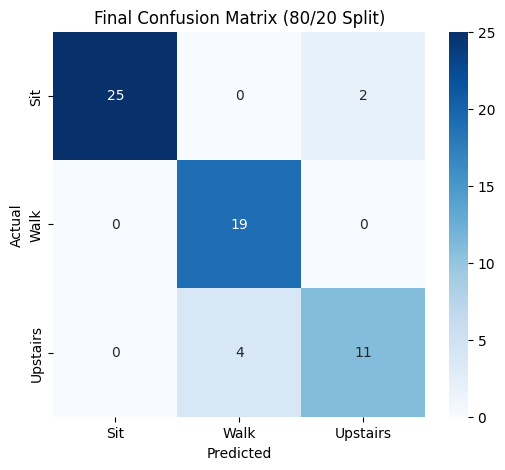

In [7]:
if __name__ == "__main__":
    train_and_evaluate_split()

In [9]:
def train_and_evaluate_kfold():
    data_raw, labels = load_activity_data()
    X, y = chunk_data_raw(data_raw, labels, CHUNK_SIZE, SAMPLING_RATE)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, 6)).reshape(X.shape)
    X_np, y_np = np.array(X), np.array(y)

    # K-Fold setup
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fold_results = []    
    all_fold_preds, all_fold_labels = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        print(f"\n=== Fold {fold+1} ===")

        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=BATCH_SIZE)

        model = TransformerClassifier().to(device)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

        warmup_epochs = 5
        val_acc_history = []

        for epoch in range(EPOCHS):
            # LR scheduler
            if epoch < warmup_epochs:
                lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
            else:
                lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (EPOCHS - warmup_epochs)))
            for pg in optimizer.param_groups:
                pg['lr'] = LEARNING_RATE * lr_scale

            #Training
            model.train()
            total_correct, total = 0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_correct += (preds.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)
            train_acc = total_correct / total * 100

            # Validation
            model.eval()
            val_correct, val_total = 0, 0
            fold_preds, fold_labels = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    val_correct += (preds.argmax(dim=1) == yb).sum().item()
                    val_total += yb.size(0)
                    fold_preds.extend(preds.argmax(dim=1).cpu().numpy())
                    fold_labels.extend(yb.cpu().numpy())
            val_acc = val_correct / val_total * 100
            val_acc_history.append(val_acc)

            if (epoch + 1) % 10 == 0 or epoch == EPOCHS - 1:
                print(f"[Fold {fold+1}] Epoch {epoch+1}/{EPOCHS} | LR: {optimizer.param_groups[0]['lr']:.6f} "
                      f"| Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Test Acc: {val_acc:.2f}%")

        fold_results.append(val_acc_history[-1])
        all_fold_preds.extend(fold_preds)
        all_fold_labels.extend(fold_labels)

        # Final Confusion matrix
        cm = confusion_matrix(fold_labels, fold_preds)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
        plt.title(f'Final Confusion Matrix - Fold {fold+1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    print("\n=== Cross-validation results ===")
    print(f"Mean Val Accuracy: {np.mean(fold_results):.2f}% ± {np.std(fold_results):.2f}%")

    print("\nClassification Report (aggregated across folds):")
    print(classification_report(all_fold_labels, all_fold_preds, target_names=ACTIVITIES, zero_division=0))

    cm = confusion_matrix(all_fold_labels, all_fold_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Aggregated Confusion Matrix (All Folds)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


=== Fold 1 ===
[Fold 1] Epoch 10/100 | LR: 0.000996 | Train Acc: 78.19% | Val Acc: 72.13% | Test Acc: 72.13%
[Fold 1] Epoch 20/100 | LR: 0.000947 | Train Acc: 86.42% | Val Acc: 80.33% | Test Acc: 80.33%
[Fold 1] Epoch 30/100 | LR: 0.000851 | Train Acc: 94.24% | Val Acc: 88.52% | Test Acc: 88.52%
[Fold 1] Epoch 40/100 | LR: 0.000716 | Train Acc: 94.65% | Val Acc: 90.16% | Test Acc: 90.16%
[Fold 1] Epoch 50/100 | LR: 0.000558 | Train Acc: 96.71% | Val Acc: 90.16% | Test Acc: 90.16%
[Fold 1] Epoch 60/100 | LR: 0.000393 | Train Acc: 97.12% | Val Acc: 93.44% | Test Acc: 93.44%
[Fold 1] Epoch 70/100 | LR: 0.000241 | Train Acc: 98.35% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 1] Epoch 80/100 | LR: 0.000116 | Train Acc: 98.77% | Val Acc: 93.44% | Test Acc: 93.44%
[Fold 1] Epoch 90/100 | LR: 0.000033 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 1] Epoch 100/100 | LR: 0.000000 | Train Acc: 98.77% | Val Acc: 95.08% | Test Acc: 95.08%


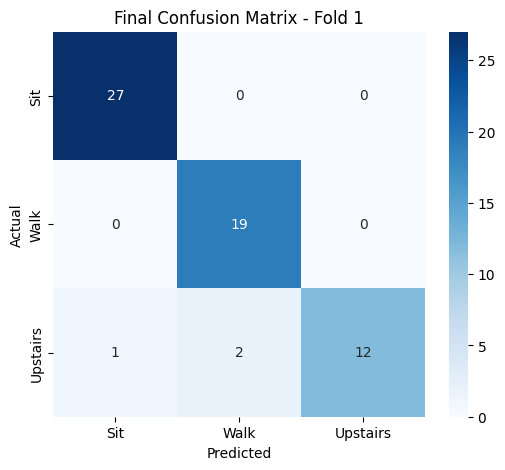


=== Fold 2 ===
[Fold 2] Epoch 10/100 | LR: 0.000996 | Train Acc: 82.30% | Val Acc: 88.52% | Test Acc: 88.52%
[Fold 2] Epoch 20/100 | LR: 0.000947 | Train Acc: 93.00% | Val Acc: 91.80% | Test Acc: 91.80%
[Fold 2] Epoch 30/100 | LR: 0.000851 | Train Acc: 96.30% | Val Acc: 96.72% | Test Acc: 96.72%
[Fold 2] Epoch 40/100 | LR: 0.000716 | Train Acc: 97.12% | Val Acc: 96.72% | Test Acc: 96.72%
[Fold 2] Epoch 50/100 | LR: 0.000558 | Train Acc: 97.53% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 2] Epoch 60/100 | LR: 0.000393 | Train Acc: 98.35% | Val Acc: 98.36% | Test Acc: 98.36%
[Fold 2] Epoch 70/100 | LR: 0.000241 | Train Acc: 99.59% | Val Acc: 98.36% | Test Acc: 98.36%
[Fold 2] Epoch 80/100 | LR: 0.000116 | Train Acc: 98.77% | Val Acc: 98.36% | Test Acc: 98.36%
[Fold 2] Epoch 90/100 | LR: 0.000033 | Train Acc: 97.53% | Val Acc: 98.36% | Test Acc: 98.36%
[Fold 2] Epoch 100/100 | LR: 0.000000 | Train Acc: 97.12% | Val Acc: 98.36% | Test Acc: 98.36%


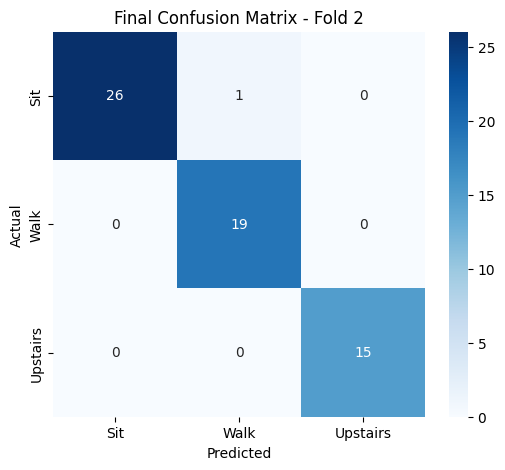


=== Fold 3 ===
[Fold 3] Epoch 10/100 | LR: 0.000996 | Train Acc: 78.19% | Val Acc: 83.61% | Test Acc: 83.61%
[Fold 3] Epoch 20/100 | LR: 0.000947 | Train Acc: 93.00% | Val Acc: 96.72% | Test Acc: 96.72%
[Fold 3] Epoch 30/100 | LR: 0.000851 | Train Acc: 95.88% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 40/100 | LR: 0.000716 | Train Acc: 96.30% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 50/100 | LR: 0.000558 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 60/100 | LR: 0.000393 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 70/100 | LR: 0.000241 | Train Acc: 99.59% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 80/100 | LR: 0.000116 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 90/100 | LR: 0.000033 | Train Acc: 100.00% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 3] Epoch 100/100 | LR: 0.000000 | Train Acc: 98.77% | Val Acc: 95.08% | Test Acc: 95.08%


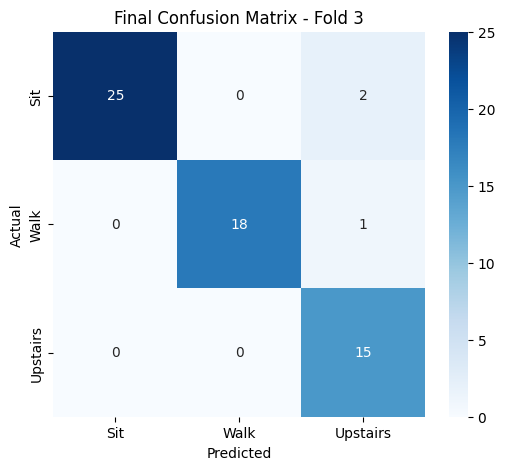


=== Fold 4 ===
[Fold 4] Epoch 10/100 | LR: 0.000996 | Train Acc: 71.60% | Val Acc: 75.41% | Test Acc: 75.41%
[Fold 4] Epoch 20/100 | LR: 0.000947 | Train Acc: 84.77% | Val Acc: 78.69% | Test Acc: 78.69%
[Fold 4] Epoch 30/100 | LR: 0.000851 | Train Acc: 94.65% | Val Acc: 91.80% | Test Acc: 91.80%
[Fold 4] Epoch 40/100 | LR: 0.000716 | Train Acc: 96.71% | Val Acc: 93.44% | Test Acc: 93.44%
[Fold 4] Epoch 50/100 | LR: 0.000558 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 4] Epoch 60/100 | LR: 0.000393 | Train Acc: 99.59% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 4] Epoch 70/100 | LR: 0.000241 | Train Acc: 99.18% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 4] Epoch 80/100 | LR: 0.000116 | Train Acc: 99.18% | Val Acc: 93.44% | Test Acc: 93.44%
[Fold 4] Epoch 90/100 | LR: 0.000033 | Train Acc: 98.77% | Val Acc: 95.08% | Test Acc: 95.08%
[Fold 4] Epoch 100/100 | LR: 0.000000 | Train Acc: 100.00% | Val Acc: 93.44% | Test Acc: 93.44%


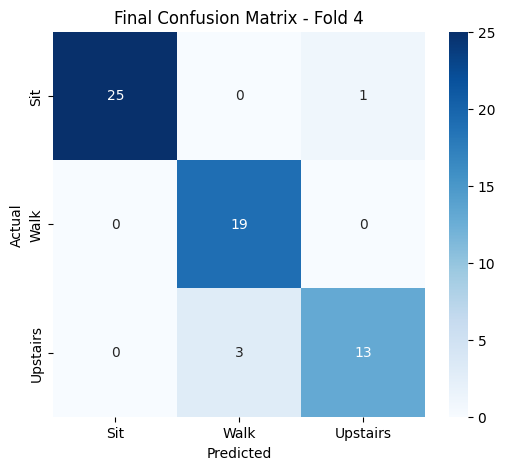


=== Fold 5 ===
[Fold 5] Epoch 10/100 | LR: 0.000996 | Train Acc: 75.41% | Val Acc: 80.00% | Test Acc: 80.00%
[Fold 5] Epoch 20/100 | LR: 0.000947 | Train Acc: 87.30% | Val Acc: 88.33% | Test Acc: 88.33%
[Fold 5] Epoch 30/100 | LR: 0.000851 | Train Acc: 95.08% | Val Acc: 93.33% | Test Acc: 93.33%
[Fold 5] Epoch 40/100 | LR: 0.000716 | Train Acc: 96.31% | Val Acc: 88.33% | Test Acc: 88.33%
[Fold 5] Epoch 50/100 | LR: 0.000558 | Train Acc: 98.36% | Val Acc: 91.67% | Test Acc: 91.67%
[Fold 5] Epoch 60/100 | LR: 0.000393 | Train Acc: 99.18% | Val Acc: 93.33% | Test Acc: 93.33%
[Fold 5] Epoch 70/100 | LR: 0.000241 | Train Acc: 98.77% | Val Acc: 91.67% | Test Acc: 91.67%
[Fold 5] Epoch 80/100 | LR: 0.000116 | Train Acc: 99.59% | Val Acc: 93.33% | Test Acc: 93.33%
[Fold 5] Epoch 90/100 | LR: 0.000033 | Train Acc: 99.18% | Val Acc: 93.33% | Test Acc: 93.33%
[Fold 5] Epoch 100/100 | LR: 0.000000 | Train Acc: 98.77% | Val Acc: 93.33% | Test Acc: 93.33%


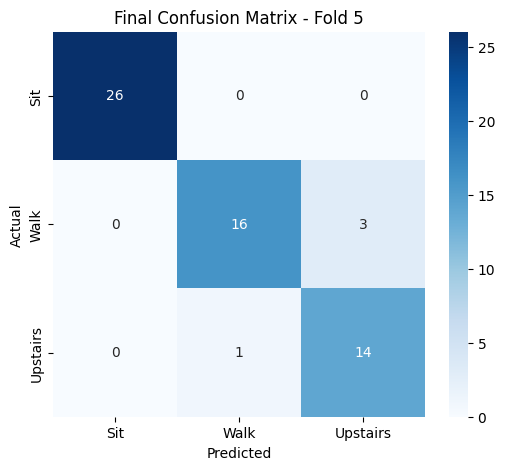


=== Cross-validation results ===
Mean Val Accuracy: 95.06% ± 1.82%

Classification Report (aggregated across folds):
              precision    recall  f1-score   support

         Sit       0.99      0.97      0.98       133
        Walk       0.93      0.96      0.94        95
    Upstairs       0.91      0.91      0.91        76

    accuracy                           0.95       304
   macro avg       0.94      0.95      0.94       304
weighted avg       0.95      0.95      0.95       304



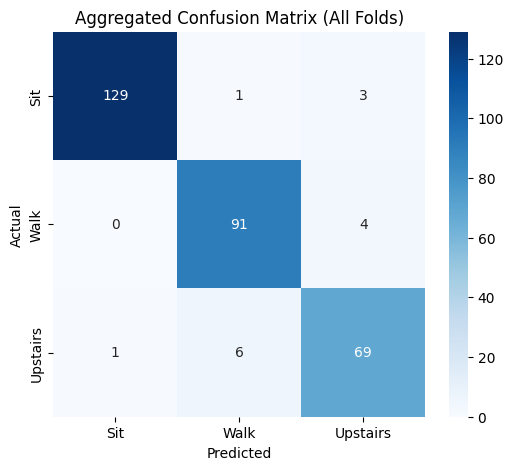

In [10]:
if __name__ == "__main__":
    train_and_evaluate_kfold()